
# Conditional autoregressive transformer

Train a transformer to predict missing pixel from mnist 

### plan

* note to try padded mnist (relative encoding might require black padding???)
* probably don't need positional encoding?
* create transformer model
* masking 
* randomised masking
* relative position encoding (x - current_x, y - current_y, val)
* train to predict when current pixel missing
* train to predict when 10% are missing
* train to predict when 90% are missing
* train to predict when 99% are missing



In [1]:
model_name = "txformer-pure"

In [2]:
# Init weights and biases project

callbacks = []

# import wandb
# from wandb.keras import WandbCallback


# wandb.init(project='conditional-mnist', entity='maxeonyx')
# config = wandb.config
# config.learning_rate = 0.01

# callbacks += [WandbCallback()]

In [3]:
# reserve GPU 0 only (for VUW machines)

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
# start tensorflow

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [5]:
from PIL import Image, ImageDraw
from IPython.display import display

def display_uint8_image(image):
    if len(image.shape) == 3:
        image = image[:, :, 0]
    if tf.is_tensor(image):
        image = image.numpy()
    display(Image.fromarray(image, "L"))

def display_float32_image(image):
    if len(image.shape) == 3:
        image = image[:, :, 0]
    if tf.is_tensor(image):
        image = image.numpy()
    display_uint8_image(image.astype(np.uint8))

In [6]:
def idxs_to_onehots(idxs, depth=784):
    onehots = tf.one_hot(idxs, depth, dtype=tf.bool, on_value=False, off_value=True)
    return onehots

# takes 2D tensor (batch and index list)
def idxs_to_multihot(idxs, depth=784):
    onehots = idxs_to_onehots(idxs, depth)
    multihot = tf.math.reduce_all(onehots, axis=len(onehots.shape)-2)
    return multihot

def idxs_to_attention_mask(idxs):
    multihot = idxs_to_multihot(idxs)
    attn_mask = tf.logical_and(multihot[:, :, None], multihot[:, None, :])
    return attn_mask

def mask_to_image_mask(mask):
    image_mask = tf.reshape(mask, [28, 28])
    return image_mask

# scale is the max-min of vals
# for mnist it's 28 because thats the width and height of the images
def positional_encoding(vals, dims, scale=1000):

    i = tf.range(dims//2, dtype=tf.float32)
    i = tf.expand_dims(i, -2)
    
    vals = tf.expand_dims(vals, -1)
    
    # the bit inside the sin / cos
    rate = vals / tf.pow(scale, 2.*i/dims)
    
    sin = tf.sin(rate)
    cos = tf.cos(rate)
    
#     # expand dims to allow alternating concat
#     sin = tf.expand_dims(sin, -1)
#     cos = tf.expand_dims(cos, -1)
    
    encoding = tf.concat([sin, cos], axis=-1)
    
#     encoding = tf.reshape(encoding, [-1, dims])
    
    return encoding

print(positional_encoding(tf.constant([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]), 8))

def img_to_tuples(img):
    
    height, width = img.shape
    length = height * width
    vals = tf.reshape(img, [length])
    vals = tf.cast(vals, tf.float32)
    rows = tf.range(height, dtype=tf.int32)
    cols = tf.range(width, dtype=tf.int32)
    cols, rows = tf.meshgrid(rows, cols)
    rows = tf.reshape(rows, [-1])
    cols = tf.reshape(cols, [-1])
    
    # permute the order, to ensure the network uses the positional encoding and not the implicit locaiton
    idxs = tf.range(length)
    idxs = tf.random.shuffle(idxs)
    
    rows = tf.gather(rows, idxs)
    cols = tf.gather(cols, idxs)
    vals = tf.gather(vals, idxs)
    
    return vals, rows, cols, idxs

def random_mask():
    idxs = tf.range(784)
    idxs = tf.random.shuffle(idxs)
    n = tf.random.uniform(shape=[], maxval=784, dtype=tf.int32)
    idxs = idxs[:n]
    mask = idxs_to_multihot(idxs)
    return mask

def random_square_mask(maxsize=28):
    height = tf.random.uniform(shape=[], minval=1, maxval=maxsize, dtype=tf.int32)
    width = tf.random.uniform(shape=[], minval=1, maxval=maxsize, dtype=tf.int32)
    start_row = tf.random.uniform(shape=[], minval=0, maxval=maxsize-height, dtype=tf.int32)
    start_col = tf.random.uniform(shape=[], minval=0, maxval=maxsize-width, dtype=tf.int32)
    rows = tf.range(start_row, start_row + height)
    cols = tf.range(start_col, start_col + width)
    cols, rows = tf.meshgrid(rows, cols)
    idxs = rows*maxsize+cols
    idxs = tf.reshape(idxs, [-1])
    return idxs_to_multihot(idxs, depth=maxsize*maxsize)

def random_offset():
    return tf.random.uniform(shape=[2], maxval=28, dtype=tf.int32)
    
def display_mask(mask):
    image_mask = np.array(mask_to_image_mask(mask), np.uint8)
    image_mask = image_mask * 255
    display_uint8_image(image_mask)

tf.Tensor(
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00]
 [ 7.0710683e-01  1.3921213e-01  2.4833918e-02  4.4166050e-03
   7.0710677e-01  9.9026257e-01  9.9969161e-01  9.9999022e-01]
 [ 1.0000000e+00  2.7571312e-01  4.9652517e-02  8.8331243e-03
  -4.3711388e-08  9.6123999e-01  9.9876654e-01  9.9996096e-01]
 [ 7.0710683e-01  4.0684462e-01  7.4440487e-02  1.3249470e-02
  -7.0710677e-01  9.1349739e-01  9.9722546e-01  9.9991220e-01]
 [-8.7422777e-08  5.3005296e-01  9.9182546e-02  1.7665559e-02
  -1.0000000e+00  8.4796453e-01  9.9506927e-01  9.9984396e-01]], shape=(5, 8), dtype=float32)


2021-10-06 18:46:35.320697: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-06 18:46:35.857357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:3b:00.0, compute capability: 7.5


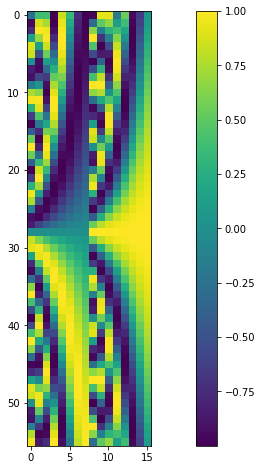

In [7]:
from matplotlib import pyplot as plt
positions = tf.range(-28, 28, dtype=tf.float32)
encodings = positional_encoding(positions, 16, scale=28)
fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(encodings)
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [8]:
# tensorflow.data data generator

from tensorflow import data as td
import tensorflow_datasets as tfds


def make_dataset_generator(x, y, seed, options={'single pixel', '256 color'}):

    
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    
    # keep track of the index in the original MNIST
    def to_dict(i, xy):
        image, label = xy
        data = {}
        data['index'] = i
        data['image'] = image
        data['label'] = label
        return data
    dataset = dataset.enumerate()
    dataset = dataset.map(to_dict)
    
    # shuffle the digits
    dataset = dataset.shuffle(1000)
    # repeat the dataset infinitely
    dataset = dataset.repeat()
    
    def to_binary_mnist(data):
        data['image'] = tf.cast(tf.round(data['image'] / 255), tf.float32)
        return data
    if '2 color' in options:
        dataset = dataset.map(to_binary_mnist)
    
    # add a transformation of MNIST images into val, row, col
    def add_tuples(data):
        data['val'], data['row'], data['col'], data['idxs'] = img_to_tuples(data['image'])
        return data
    dataset = dataset.map(add_tuples)
    
    # create a mask of random pixels masked out
    def add_mask(data):
        data['mask'] = random_mask()
        return data
    dataset = dataset.map(add_mask)
    
    # mask out a square region as well as random pixels
    def add_square_mask(data):
        mask = data['mask']
        square_mask = random_square_mask()
        data['mask'] = tf.logical_and(mask, square_mask)
        return data
    dataset = dataset.map(add_square_mask)
    
    def shuffle_mask(data):
        data['mask'] = tf.gather(data['mask'], data['idxs'])
        return data
    dataset = dataset.map(shuffle_mask)
    
    # generate training pairs
    
    def single_pixel(data):
        data['target_val'] = tf.cast(data['image'][data['target_row'], data['target_col']], tf.float32)
        
        mask_out_target_pixel = True
        if mask_out_target_pixel:
            target_idx = data['target_row'] * 28 + data['target_col']
            target_mask = idxs_to_onehots(target_idx)
            data['mask'] = tf.logical_and(data['mask'], target_mask)
        
        # offset positions relative to target pixel so target is at 0,0
        data['row'] = data['row'] - tf.cast(data['target_row'], tf.float32)
        data['col'] = data['col'] - tf.cast(data['target_col'], tf.float32)
        
        return (data, data['target_val'])
    
    def single_pixel_random_rowcol(data):
        data['target_row']  = tf.random.uniform([], minval=0, maxval=28, dtype=tf.int32)
        data['target_col']  = tf.random.uniform([], minval=0, maxval=28, dtype=tf.int32)
        
        return single_pixel(data)
        
    def many_single_pixels(data):
        rows = tf.range(28)
        cols = tf.range(28)
        cols, rows = tf.meshgrid(rows, cols)
        
        rows = tf.reshape(rows, [-1])
        cols = tf.reshape(cols, [-1])
        
        image = data['image']
        val = data['val']
        row = data['row']
        col = data['col']
        mask = data['mask']
        label = data['label']
        index = data['index']
        
        def data_plus_pixel_index(i):
            new_datum = {}
            new_datum['pix_index'] = i
            new_datum['target_row'] = rows[i]
            new_datum['target_col'] = cols[i]
            return new_datum
        
        def add_original(new_datum):
            
            new_datum['index'] = index
            new_datum['val'] = val
            new_datum['row'] = row
            new_datum['col'] = col
            new_datum['image'] = image
            new_datum['mask'] = mask
            new_datum['label'] = label
            
            return new_datum
        
        d = tf.data.Dataset.range(784)
        d = d.map(data_plus_pixel_index)
        d = d.map(add_original)
        d = d.map(single_pixel)
        
        return d
    
    def whole_image(data):
        return data, data['val']
    
    # single pixel example. the row & col are translated by a random
    # amount and the target val is the new pixel at 0,0
    if 'single pixel' in options:
        dataset = dataset.map(single_pixel_random_rowcol)
    
    # 'many single pixels' generates 784 single pixels from each image,
    # and the target vals are each pixel in turn, translated so that
    # they are at 0,0
    elif 'many single pixels' in options:
        dataset = dataset.interleave(many_single_pixels, block_length=784)
    
    elif 'whole image' in options:
        dataset = dataset.map(whole_image)
    
    return dataset
    
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

def make_datasets(options):

    train = make_dataset_generator(x_train, y_train, seed=192_168_1_1, options=options)
    test = make_dataset_generator(x_test, y_test, seed=10_1_1_1, options=options)
    
    return train, iter(test)
options={'whole image', '256 color'}
dataset_train, dataset_test = make_datasets(options)

2021-10-06 18:46:38.519669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [30]:


def shape_summary(data):
    for name, v in data.items():
        print(name, "shape", v.shape)
        print(name, "dtype", v.dtype)

def el_summary(data, outputs=None):
    print("index", data["index"].numpy(), "which is a", data["label"].numpy())
    if 'pix_index' in data:
        print("pix_idx:", data["pix_index"].numpy())

    image = np.zeros([28, 28])
    image[data['row'], data['col']] = data['val']
    mask = np.zeros([28, 28], dtype=np.bool_)
    mask[data['row'], data['col']] = data['mask']
    
    if outputs is not None:
        output_image = np.zeros([28, 28])
        output_image[data['row'], data['col']] = np.reshape(outputs, [784])
        outputs = output_image
        
    if '2 color' in options:
        if outputs is not None:
            outputs = outputs * 255.
        image = image * 255.
        
    display_float32_image(image)
    display_float32_image(tf.cast(mask, tf.float32) * 255)
    display_float32_image(image * tf.cast(mask, tf.float32))
    
    if outputs is not None:
        print('input sum', np.sum(data['val']))
        print('output sum', np.sum(outputs))
        display_float32_image(outputs)

def train_summary(d):
    data, target = next(iter(d))
    shape_summary(data)
    el_summary(data)
    data, target = next(iter(d))
    el_summary(data)

def test_summary(d):
    data, target = next(d)
    shape_summary(data)
    el_summary(data)
    data, target = next(d)
    el_summary(data)
    for i in range(780):
        next(d)
    data, target = next(d)
    el_summary(data)
    data, target = next(d)
    el_summary(data)
    data, target = next(d)
    el_summary(data)
    data, target = next(d)
    el_summary(data)

train_summary(dataset_train)


# TODO: TEST DATASET GENERATOR DOES NOT WORK HOW I EXPECT.
#       IT SHOULD PRODUCE 784 EXAMPLES with the SAME image and mask, then change
#       to a different image and mask.

test_summary(dataset_test)

# reset datasets after summary, because it consumes elements
dataset_train, dataset_test = make_datasets(options)

index shape ()
index dtype <dtype: 'int64'>
image shape (28, 28)
image dtype <dtype: 'uint8'>
label shape ()
label dtype <dtype: 'uint8'>
val shape (784,)
val dtype <dtype: 'float32'>
row shape (784,)
row dtype <dtype: 'int32'>
col shape (784,)
col dtype <dtype: 'int32'>
idxs shape (784,)
idxs dtype <dtype: 'int32'>
mask shape (784,)
mask dtype <dtype: 'bool'>
index 244 which is a 5


index 670 which is a 3


index shape ()
index dtype <dtype: 'int64'>
image shape (28, 28)
image dtype <dtype: 'uint8'>
label shape ()
label dtype <dtype: 'uint8'>
val shape (784,)
val dtype <dtype: 'float32'>
row shape (784,)
row dtype <dtype: 'int32'>
col shape (784,)
col dtype <dtype: 'int32'>
idxs shape (784,)
idxs dtype <dtype: 'int32'>
mask shape (784,)
mask dtype <dtype: 'bool'>
index 677 which is a 3


index 253 which is a 5


index 1525 which is a 5


index 1599 which is a 4


index 1388 which is a 6


index 732 which is a 6


## Attention Maths

Dimensions $N$, $D$, $E$ and $B$.

- $N = 784$ is the number of inputs.
- $D$ is the width of the _key_ $K$ and _query_ $Q$ vectors.
- $E$ is the width of the _value_ vectors $V$.
- There is also a (or multiple) batch dimension(s) $B$.

$K$ is $B \times N \times D$ dimensional.
$Q$ is $B \times N \times D$ dimensional.
$V$ is $B \times N \times E$ dimensional.
Because it is self-attention, $K$ and $Q$ have the same length $N$, and the attention matrix is square.
The attention matrix is $A = Q \cdot K^T$, and is $B \times N \times N$ dimensional. Formally:
$$
A_{b,i,j} = \sum_d Q_{b,i,d} K_{b,j,d}
$$

We do softmax normalization along the columns $j$ of the attention matrix (such that each _row_ $i$ sums to 1). The result is the attention weights. Formally:
$$
\bar{A}_{b,i,j} = \frac{e^{A_{b,i,j}}}{\sum_{j'} e^{A_{b,i,j'}}}
$$

The output $O$ of the attention layer is $B \times N \times E$ dimensional. It is obtained by the attention weights multiplied by the value vectors $V$. $A$ is $B \times N \times N$ dimensional and $V$ is $B \times N \times E$ dimensional.
$$
    O_{b,i,e} = \sum_j A_{b,i,j} V_{b,j,e}
$$

Often the dimensions $E = D$ because this allows multiple attention layers in sequence, but this need not be the case.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers


def multi_head_attention(n_heads, n_kq_dim, n_val_dim):
    
    k_dense = layers.Dense(n_kq_dim, activation='linear')
    q_dense = layers.Dense(n_kq_dim, activation='linear')
    
    
    
    softmax = layers.Softmax(axis=-1)
    
    val_dense = layers.Dense(n_val_dim, activation='relu')
    
    def call(inputs, mask):
        
        k = k_dense(inputs)
        q = q_dense(inputs)
        
        scores = tf.matmul(query, key, transpose_b=True)
        weights = softmax(scores, mask)
        
        vals = val_dense(inputs)
        
        vals = tf.expand_dims(-1)
        weights = tf.expand_dims(-2)
        
        outputs = tf.reduce_sum(vals * weights)
        
        
        vals *= mask
        

def transformer_block(n_embed_dim, n_heads, n_dense_dim, dropout_rate, output_shape=None):
    
    attn = layers.MultiHeadAttention(num_heads=n_heads, key_dim=n_embed_dim, output_shape=output_shape)
    dense_net_1 = layers.Dense(n_dense_dim, activation='relu')
    dense_net_2 = layers.Dense(n_embed_dim if output_shape is None else output_shape)
    layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    if dropout_rate is not None:
        dropout1 = layers.Dropout(dropout_rate)
        dropout2 = layers.Dropout(dropout_rate)
    
    def call(inputs, masks, include_residual, separate_query=None):
        mask = tf.logical_and(masks[:, :, None], masks[:, None, :])
        if separate_query is not None:
            m = attn(inputs, separate_query, attention_mask=mask)
        else:
            m = attn(inputs, inputs, attention_mask=mask)
        if dropout_rate is not None:
            m = dropout1(m)
        attn_output = m
        if include_residual:
            m = inputs + m
#         # mask outputs. important! without, model learns magic powers (can detect and use verrrrrrry small numbers which are not literally 0)
#         m = m * tf.expand_dims(tf.cast(masks, tf.float32), -1)
        m = layernorm1(m)
        m = dense_net_1(m)
        m = dense_net_2(m)
        if dropout_rate is not None:
            m = dropout2(m)
        dense_output = m
        return layernorm2(attn_output + dense_output)
    
    return call
    


In [11]:
x = tf.constant([[[1,2],[3,4]]])
print(tf.tile(x, multiples=[3, 1, 1]))

tf.Tensor(
[[[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]], shape=(3, 2, 2), dtype=int32)


In [12]:
def model(batch_size):

    # no batch size to start makes it simpler
    n_embd = 20
    value_dim = 40
    pointwise_feedforward_dim = 200

    val = keras.Input(shape=[784], name='val', batch_size=batch_size)
    row = keras.Input(shape=[784], name='row', batch_size=batch_size)
    col = keras.Input(shape=[784], name='col', batch_size=batch_size)
    mask = keras.Input(shape=[784], name='mask', batch_size=batch_size, dtype=tf.bool)
    
    print(val.shape)
    print(row.shape)
    print(col.shape)
    print(mask.shape)
    
    row_pos_enc = positional_encoding(row, n_embd//2)
    col_pos_enc = positional_encoding(col, n_embd//2)
    
    print(row_pos_enc.shape)
    print(col_pos_enc.shape)
    
    pos_enc = tf.concat([row_pos_enc, col_pos_enc], axis=-1)
    print(pos_enc.shape)
    
    # produce images of the attention/relevance/contribution for each output.

    # make it smaller
    # - less heads
    # - less dense layers
    # - smaller layer sizes'
    
    # look at standard transformer structure again.
    # what is the expected training time?
    
    # simple setup -> build up.
    
    # literature / other task at the same time
    # have enough to get help from supervisors in discussion
    # start writing
    
    # make n_embd-dimensional input embeddings per pixel from [x, y, v]
    # embedding
    
    m = tf.expand_dims(val, -1)
#     m = tf.stack([val, row, col], axis=-1)

    m = layers.Dense(pointwise_feedforward_dim, activation='relu')(m)
    m = layers.Dense(n_embd, activation=None)(m)
    
#     print(m.shape)

    rows_unshuffled = tf.range(28, dtype=tf.float32)
    cols_unshuffled = tf.range(28, dtype=tf.float32)
    cols_unshuffled, rows_unshuffled = tf.meshgrid(rows_unshuffled, cols_unshuffled)
    rows_unshuffled = tf.reshape(rows_unshuffled, [-1])
    cols_unshuffled = tf.reshape(cols_unshuffled, [-1])
    
    row_unsh_pos_enc = positional_encoding(rows_unshuffled, n_embd//2)
    col_unsh_pos_enc = positional_encoding(cols_unshuffled, n_embd//2)
    
    unsh_pos_enc = tf.concat([row_unsh_pos_enc, col_unsh_pos_enc], axis=-1)
    unsh_pos_enc = tf.expand_dims(unsh_pos_enc, axis=0)
    unsh_pos_enc = tf.tile(unsh_pos_enc, multiples=[tf.shape(val)[0], 1, 1])
    
    m = m * tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)
    
    m = m + pos_enc
    
    m = transformer_block(n_embed_dim=n_embd, n_heads=16, n_dense_dim=pointwise_feedforward_dim, dropout_rate=None)(m, masks=mask, include_residual=True)
    m = transformer_block(n_embed_dim=n_embd, n_heads=16, n_dense_dim=pointwise_feedforward_dim, dropout_rate=None)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, output_shape=1, n_heads=1, n_dense_dim=pointwise_feedforward_dim, dropout_rate=None)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=None)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=1, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
    
#     m = layers.Dense(784, activation='relu')(m)
    m = layers.Dense(1, activation=None)(m)
    
    target_val = layers.Reshape([784], name='target_val')(m)
    
    model = keras.Model(inputs=[val, row, col, mask], outputs=[target_val])

    return model


In [13]:
batch_size=8

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
lr_metric = get_lr_metric(optimizer)

txformer = model(batch_size)
txformer.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

load_saved_model = False
if load_saved_model:
    txformer.load_weights(f"./models/{model_name}")

txformer.summary()


(8, 784)
(8, 784)
(8, 784)
(8, 784)
(8, 784, 10)
(8, 784, 10)
(8, 784, 20)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
row (InputLayer)                [(8, 784)]           0                                            
__________________________________________________________________________________________________
col (InputLayer)                [(8, 784)]           0                                            
__________________________________________________________________________________________________
val (InputLayer)                [(8, 784)]           0                                            
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (8, 784, 1)          0           row[0][0]                        
___________________

In [22]:

# display:
# - before mask
# - mask
# - after mask
# - prediction
def gen_image(dataset):
    
    data, targ = next(dataset)
    
    inputs = [data['val'], data['row'], data['col'], data['mask']]
    inputs = [tf.expand_dims(x, 0) for x in inputs]

    outputs = tf.clip_by_value(txformer(inputs), 0, 255)
    
    el_summary(data, outputs)

def gen_image_many_pixels(dataset):
    
    # assume dataset is a 'many single pixel dataset'
    # so it has runs of 784 examples, one for each pixel in an mnist digit
#     dataset = dataset.take(784)
#     batch_size = 32
#     dataset = dataset.batch(batch_size)
#     reconstructed_image = np.zeros([28, 28])
#     for batch, batch_targ in dataset:
#         inputs = [batch['val'], batch['row'], batch['col'], batch['mask']]
#         out_vals = txformer(inputs)
        
#         # np can do this yay
#         reconstructed_image[batch['target_row'], batch['target_col']] = out_vals

    reconstructed_image = np.ones([28, 28]) * 230
    for row in range(28):
        for col in range(28):
            data, targ = next(dataset)
            inputs = [data['val'], data['row'], data['col'], data['mask']]
            inputs = [tf.expand_dims(x, 0) for x in inputs]
            
            out_vals = txformer(inputs)
            reconstructed_image[data['target_row'], data['target_col']] = out_vals
    
    reconstructed_image = np.clip(reconstructed_image, 0, 255)
    image = data['image']
    mask = data['mask']
    
    if '2 color' in options:
        outputs = outputs * 255.
        image = image  * 255.
    
    print("index", data["index"], "which is a", data["label"])
    display_float32_image(image)
    display_mask(mask)
    display_float32_image(tf.reshape(image, [28, 28]) * tf.cast(mask_to_image_mask(mask), tf.float32))
    display_float32_image(reconstructed_image)
        
        
def image_performance_test(n=5):
    for i in range(n):
        gen_image(dataset_test)

def fit_one_epoch(dataset):
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10000)
    
    global callbacks
    callbacks += []
    
    txformer.fit(dataset, epochs=1, steps_per_epoch=5000, batch_size=batch_size, callbacks=callbacks)


In [32]:
image_performance_test()

index 682 which is a 1


input sum 11222.0
output sum 17542.11295849085


index 561 which is a 0


input sum 24379.0
output sum 17071.892352581024


index 31 which is a 1


input sum 10822.0
output sum 13969.342437803745


index 502 which is a 5


input sum 23399.0
output sum 17354.817646980286


index 616 which is a 9


input sum 20578.0
output sum 22874.98878020048


In [33]:
fit_one_epoch(dataset_train)

5000/5000 [==============================] - 264s 53ms/step - loss: 3905.8789


In [34]:
image_performance_test()


index 982 which is a 3


input sum 25757.0
output sum 24709.29302841425


index 580 which is a 8


input sum 40181.0
output sum 21296.284291684628


index 361 which is a 6


input sum 29244.0
output sum 18277.122739315033


index 476 which is a 1


input sum 15129.0
output sum 21256.226042985916


index 540 which is a 5


input sum 29009.0
output sum 22439.498246490955


In [35]:
fit_one_epoch(dataset_train)

5000/5000 [==============================] - 263s 53ms/step - loss: 3614.6680


In [36]:
image_performance_test()


index 1011 which is a 1


input sum 17424.0
output sum 20710.97443974018


index 709 which is a 8


input sum 30953.0
output sum 27001.485913336277


index 323 which is a 3


input sum 19643.0
output sum 20088.775872945786


index 987 which is a 7


input sum 19691.0
output sum 23686.451408088207


index 698 which is a 4


input sum 24626.0
output sum 21056.394790291786


In [37]:
fit_one_epoch(dataset_train)

5000/5000 [==============================] - 263s 53ms/step - loss: 3806.5583


In [38]:
image_performance_test()


index 88 which is a 6


input sum 27590.0
output sum 26694.51967304945


index 795 which is a 3


input sum 17392.0
output sum 26130.74269783497


index 462 which is a 6


input sum 45212.0
output sum 33027.948736965656


index 662 which is a 9


input sum 21419.0
output sum 22964.568260788918


index 2 which is a 1


input sum 9871.0
output sum 19816.608904600143


In [39]:


if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")

In [40]:
gen_image(dataset_test, 20)

index 783 which is a 1


input sum 10146.0
output sum 24969.84980380535


index 478 which is a 5


input sum 19478.0
output sum 22747.661604881287


index 828 which is a 2


input sum 22782.0
output sum 25840.06425356865


index 785 which is a 5


input sum 26804.0
output sum 26496.5090944767


index 196 which is a 1


input sum 18991.0
output sum 24215.106306493282


index 713 which is a 0


input sum 21853.0
output sum 21440.964645028114


index 19 which is a 4


input sum 16034.0
output sum 26944.490490853786


index 703 which is a 7


input sum 23225.0
output sum 21152.087870955467


index 326 which is a 2


input sum 22001.0
output sum 18335.94485217333


index 801 which is a 3


input sum 39030.0
output sum 28519.656263411045


index 259 which is a 6


input sum 29983.0
output sum 29756.433412253857


index 106 which is a 2


input sum 29633.0
output sum 26502.76775276661


index 225 which is a 2


input sum 26047.0
output sum 22251.103130817413


index 863 which is a 2


input sum 24118.0
output sum 24041.260449767113


index 138 which is a 6


input sum 28217.0
output sum 28593.081974744797


index 743 which is a 6


input sum 21397.0
output sum 25651.04372727871


index 879 which is a 8


input sum 28369.0
output sum 23878.928893864155


index 767 which is a 1


input sum 10412.0
output sum 26345.055148422718


index 15 which is a 5


input sum 21818.0
output sum 26783.47121655941


index 595 which is a 3


input sum 22867.0
output sum 23733.382613241673


In [41]:
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)

5000/5000 [==============================] - 262s 52ms/step - loss: 3099.9211


In [42]:
for i in range(20):
    gen_image(dataset_test, i)

index 583 which is a 2


input sum 25947.0
output sum 28075.747898101807


index 84 which is a 8


input sum 28286.0
output sum 26401.379949212074


index 740 which is a 4


input sum 21318.0
output sum 23935.921601593494


index 754 which is a 1


input sum 11359.0
output sum 14909.709351420403


index 127 which is a 5


input sum 26419.0
output sum 24001.733306884766


index 442 which is a 3


input sum 30972.0
output sum 25253.761538386345


index 633 which is a 2


input sum 25323.0
output sum 27149.906782507896


index 592 which is a 0


input sum 34846.0
output sum 28265.90002810955


index 719 which is a 4


input sum 36884.0
output sum 27951.20876646042


index 435 which is a 8


input sum 27181.0
output sum 27730.989304304123


index 169 which is a 4


input sum 19749.0
output sum 25147.876668453217


index 652 which is a 1


input sum 14459.0
output sum 18996.911662459373


index 624 which is a 2


input sum 18688.0
output sum 21153.35880815983


index 753 which is a 3


input sum 27630.0
output sum 26903.689906060696


index 446 which is a 6


input sum 33048.0
output sum 24243.853906571865


index 997 which is a 0


input sum 45662.0
output sum 36116.91494703293


index 186 which is a 2


input sum 38892.0
output sum 28735.548405885696


index 349 which is a 3


input sum 19351.0
output sum 25489.358565986156


index 793 which is a 8


input sum 33401.0
output sum 33033.74656403065


index 924 which is a 2


input sum 27925.0
output sum 27054.722460508347


In [43]:


if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")

In [44]:
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
image_performance_test(n=20)
if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")

5000/5000 [==============================] - 263s 53ms/step - loss: 3111.5454
index 250 which is a 4


input sum 35463.0
output sum 32330.676359415054


index 100 which is a 6


input sum 18170.0
output sum 23454.109315276146


index 804 which is a 0


input sum 30806.0
output sum 29180.419386982918


index 66 which is a 6


input sum 23795.0
output sum 23244.538970589638


index 321 which is a 2


input sum 19154.0
output sum 22008.520922899246


index 45 which is a 5


input sum 19963.0
output sum 20075.34405261278


index 215 which is a 0


input sum 31856.0
output sum 29267.598794817924


index 301 which is a 7


input sum 32061.0
output sum 27447.298086106777


index 840 which is a 1


input sum 21193.0
output sum 28018.228567123413


index 579 which is a 7


input sum 18773.0
output sum 18646.377883434296


index 479 which is a 9


input sum 22686.0
output sum 43417.30767869949


index 344 which is a 8


input sum 24367.0
output sum 22900.655434012413


index 218 which is a 5


input sum 18539.0
output sum 22783.38755071163


index 431 which is a 8


input sum 20515.0
output sum 25340.555915772915


index 35 which is a 2


input sum 29258.0
output sum 29786.812684118748


index 724 which is a 6


input sum 17015.0
output sum 18622.89359176159


index 968 which is a 4


input sum 20515.0
output sum 24509.987374722958


index 659 which is a 2


input sum 30455.0
output sum 23995.32685416937


index 781 which is a 8


input sum 18725.0
output sum 24359.628769636154


index 841 which is a 7


input sum 23162.0
output sum 25793.170220911503


In [45]:
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
image_performance_test(n=20)
if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")

5000/5000 [==============================] - 263s 53ms/step - loss: 3071.9353
index 184 which is a 8


input sum 24713.0
output sum 27297.723465442657


index 336 which is a 9


input sum 28400.0
output sum 28266.55784189701


index 365 which is a 0


input sum 21722.0
output sum 30266.80132162571


index 679 which is a 7


input sum 18077.0
output sum 26063.756625771523


index 1018 which is a 8


input sum 32156.0
output sum 25599.698535084724


index 188 which is a 0


input sum 37721.0
output sum 31880.820733189583


index 976 which is a 3


input sum 22132.0
output sum 26887.407826304436


index 685 which is a 8


input sum 23718.0
output sum 27169.387247681618


index 631 which is a 8


input sum 33198.0
output sum 27657.34583234787


index 1046 which is a 5


input sum 17829.0
output sum 25254.115487337112


index 268 which is a 8


input sum 29713.0
output sum 27472.55358529091


index 213 which is a 3


input sum 15762.0
output sum 24424.84722304344


index 455 which is a 1


input sum 16574.0
output sum 17000.963413119316


index 766 which is a 5


input sum 45152.0
output sum 34729.667578697205


index 581 which is a 0


input sum 31040.0
output sum 29478.79908132553


index 1097 which is a 1


input sum 9588.0
output sum 16113.67172384262


index 529 which is a 1


input sum 14745.0
output sum 18943.434506893158


index 199 which is a 2


input sum 37987.0
output sum 21725.69131219387


index 668 which is a 4


input sum 21038.0
output sum 25820.66773235798


index 1025 which is a 1


input sum 13218.0
output sum 28547.19779598713


In [ ]:
txformer.save_weights(f"./models/working_after_long_break")